## Importando bibliotecas necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose

## Carga de datos

In [2]:
dataset = pd.read_excel('../resources/2_preprocessed/dataset_completo.xlsx')
dataset['Fecha'] = pd.to_datetime(dataset['Fecha'])
dataset.set_index('Fecha', inplace=True)

## Visualización inicial

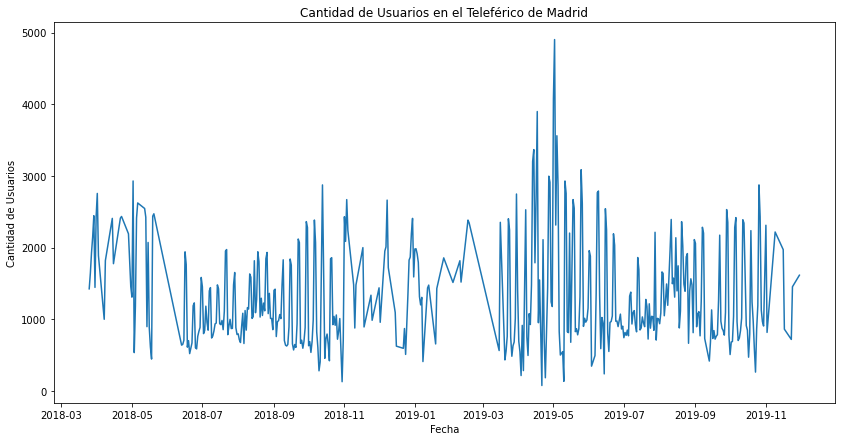

In [3]:
plt.figure(figsize=(14,7))
plt.plot(dataset['CantidadUsuarios'])
plt.title("Cantidad de Usuarios en el Teleférico de Madrid")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de Usuarios")
plt.show()

## Descomposición de la serie temporal con STL

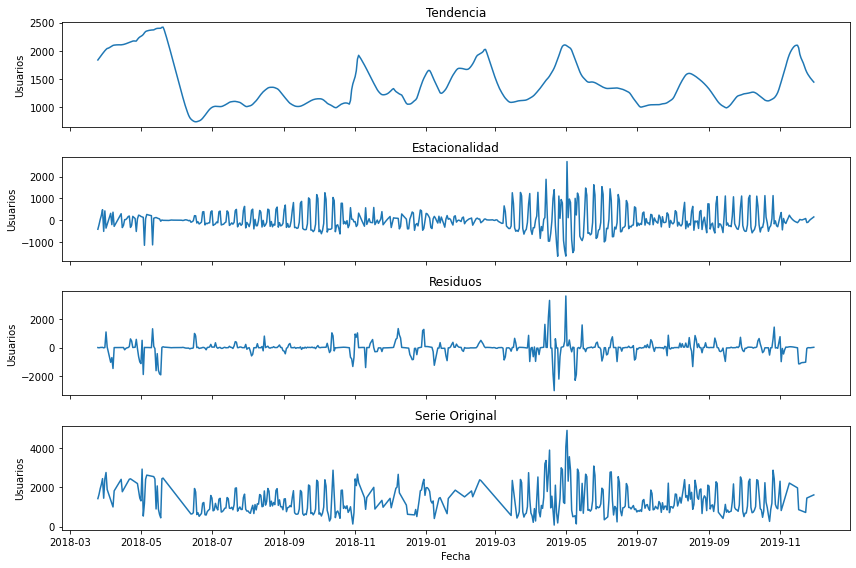

In [4]:
# Aplicar STL a 'CantidadUsuarios'
stl = STL(dataset['CantidadUsuarios'], seasonal=5, robust=True)
result = stl.fit()

# Crear una figura y un conjunto de subtramas
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(12, 8), sharex=True)

# Tendencia
ax1.plot(result.trend)
ax1.set_title('Tendencia')
ax1.set_ylabel('Usuarios')

# Estacionalidad
ax2.plot(result.seasonal)
ax2.set_title('Estacionalidad')
ax2.set_ylabel('Usuarios')

# Residuos
ax3.plot(result.resid)
ax3.set_title('Residuos')
ax3.set_ylabel('Usuarios')

# Serie original
ax4.plot(dataset['CantidadUsuarios'])
ax4.set_title('Serie Original')
ax4.set_ylabel('Usuarios')
ax4.set_xlabel('Fecha')

# Mostrar todo en una figura
plt.tight_layout()
plt.show()

## Definición de funciones

In [5]:
# Detectar outliers usando el IQR
def detect_outliers_iqr(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    outliers = data[(data < lwr_bound) | (data > upr_bound)]
    return outliers

In [6]:
# Tratamiento de outliers usando la estacionalidad
def treat_outliers_with_seasonality(data, seasonal_data, outliers):
    data_corrected = data.copy()
    for index in outliers.index:
        data_corrected.loc[index] = data.loc[index] - seasonal_data.loc[index]
    return data_corrected

In [7]:
def treat_outliers_with_residuals(original_data, resid_data):
    # Calcular límites para outliers usando IQR en los residuos
    q1 = resid_data.quantile(0.25)
    q3 = resid_data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Detectar outliers
    outliers_indices = resid_data[(resid_data < lower_bound) | (resid_data > upper_bound)].index
    
    # Corregir outliers
    corrected_data = original_data.copy()
    for index in outliers_indices:
        corrected_value = original_data.loc[index] - resid_data.loc[index] + resid_data.median()
        corrected_data.loc[index] = corrected_value

    return corrected_data

In [8]:
def treat_outliers_with_trend(original_data, trend_data):
    # Calcular la diferencia entre los datos originales y la tendencia
    difference = original_data - trend_data
    
    # Calcular límites para outliers usando IQR en la diferencia
    q1 = difference.quantile(0.25)
    q3 = difference.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Detectar outliers
    outliers_indices = difference[(difference < lower_bound) | (difference > upper_bound)].index
    
    # Corregir outliers
    corrected_data = original_data.copy()
    for index in outliers_indices:
        corrected_value = trend_data.loc[index]
        corrected_data.loc[index] = corrected_value

    return corrected_data


## Visualización de outliers

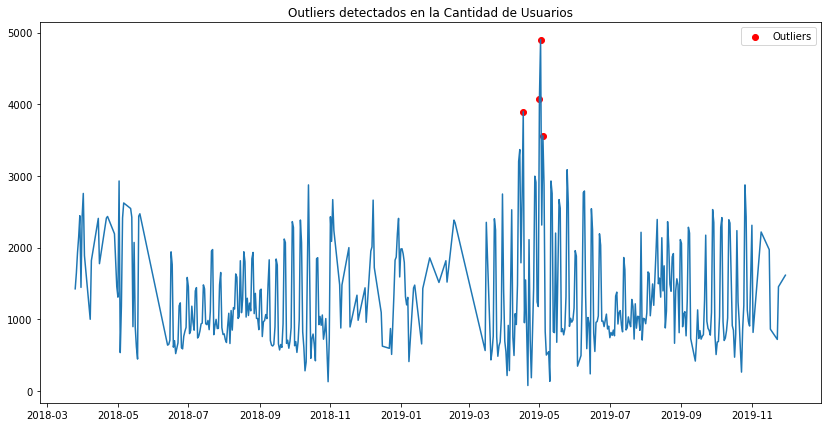

In [9]:
outliers = detect_outliers_iqr(dataset['CantidadUsuarios'])

plt.figure(figsize=(14,7))
plt.plot(dataset['CantidadUsuarios'])
plt.scatter(outliers.index, outliers.values, color='red', label='Outliers')
plt.title("Outliers detectados en la Cantidad de Usuarios")
plt.legend()
plt.show()

In [10]:
data_without_seasonality = dataset['CantidadUsuarios'] - result.seasonal #seasonal_decompose(dataset['CantidadUsuarios'], model='additive')
def detect_outliers_iqr_2(data):
    outliers = []
    data_sorted = sorted(data)
    q1 = np.percentile(data_sorted, 25)
    q3 = np.percentile(data_sorted, 75)
    IQR = q3 - q1
    lower_bound = q1 - (1.5 * IQR)
    upper_bound = q3 + (1.5 * IQR)
    
    for idx, value in enumerate(data):
        if value < lower_bound or value > upper_bound:
            outliers.append(idx)
    
    return outliers

outliers_indices = detect_outliers_iqr(data_without_seasonality)
def treat_outliers(data, outliers_indices):
    corrected_data = data.copy()
    for idx in outliers_indices:
        if idx > 0 and idx < len(data) - 1:
            corrected_data[idx] = (data[idx-1] + data[idx+1]) / 2
        elif idx == 0:
            corrected_data[idx] = data[idx+1]
        else:
            corrected_data[idx] = data[idx-1]
    return corrected_data

corrected_data_without_seasonality = treat_outliers(data_without_seasonality.values, outliers_indices)
corrected_data = corrected_data_without_seasonality + result.seasonal #seasonal_decompose(dataset['CantidadUsuarios'], model='additive')
# Visualización después de tratar outliers
plt.figure(figsize=(14,7))
plt.plot(dataset.index, dataset['CantidadUsuarios'], label='Original Data', color='blue')
plt.plot(dataset.index, corrected_data, label='Corrected Data', color='red', linestyle='--')
plt.xlabel("Fecha")
plt.ylabel("Cantidad de Usuarios")
plt.show()


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

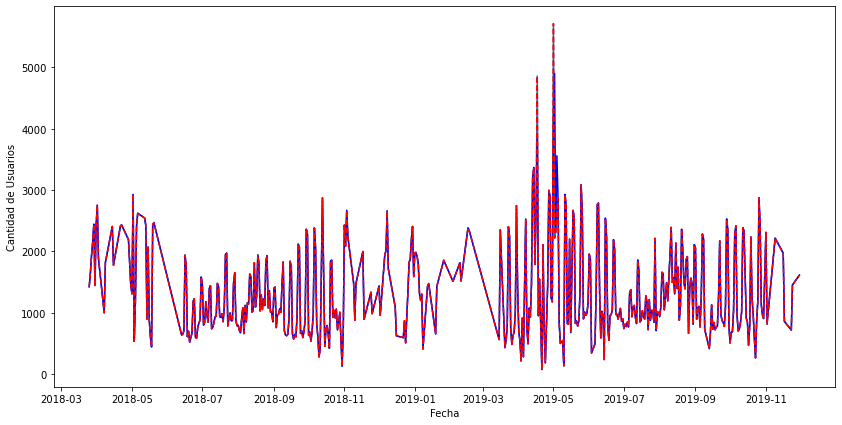

In [ ]:
# Tratamiento de outliers usando la estacionalidad
def treat_outliers_with_seasonality(data, seasonal_data):
    data_corrected = data.copy()
    for index in outliers.index:
        data_corrected.loc[index] = data.loc[index] - seasonal_data.loc[index]
    return data_corrected

dataset_corrected = treat_outliers_with_seasonality(dataset['CantidadUsuarios'], result.seasonal)

# Visualización después de tratar outliers
plt.figure(figsize=(14,7))
plt.plot(dataset_corrected)
plt.plot(dataset.index, dataset['CantidadUsuarios'], label='Original Data', color='blue')
plt.plot(dataset.index, dataset_corrected, label='Corrected Data', color='red', linestyle='--')
plt.xlabel("Fecha")
plt.ylabel("Cantidad de Usuarios")
plt.show()

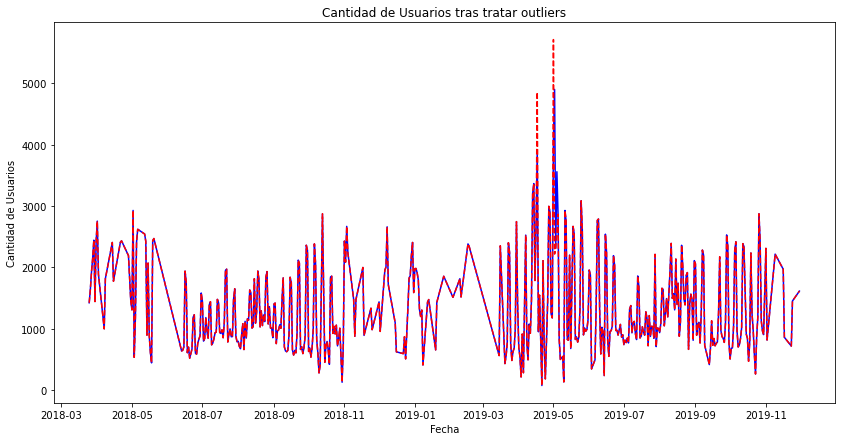

In [ ]:
dataset_corrected = treat_outliers_with_seasonality(dataset['CantidadUsuarios'], result.seasonal, outliers)

# Visualización después de tratar outliers
plt.figure(figsize=(14,7))
plt.plot(dataset.index, dataset['CantidadUsuarios'], label='Original Data', color='blue')
plt.plot(dataset.index, dataset_corrected, label='Corrected Data', color='red', linestyle='--')
plt.title("Cantidad de Usuarios tras tratar outliers")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de Usuarios")
plt.show()

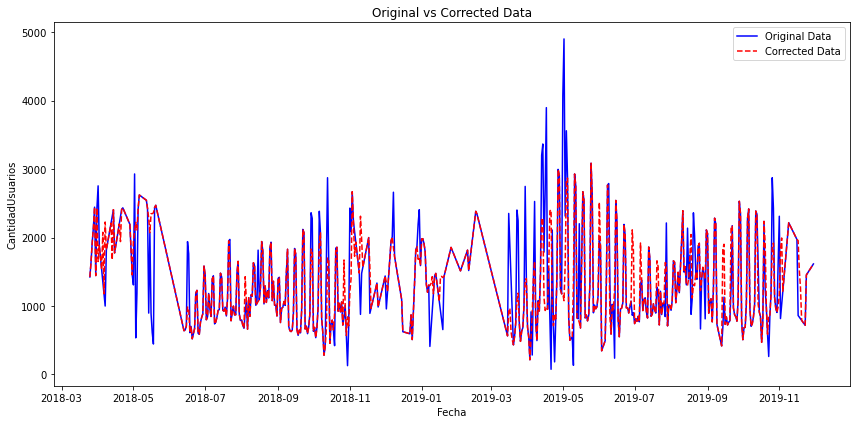

In [ ]:
corrected_data = treat_outliers_with_residuals(dataset['CantidadUsuarios'], result.resid)

# Visualización
plt.figure(figsize=(12, 6))
plt.plot(dataset.index, dataset['CantidadUsuarios'], label='Original Data', color='blue')
plt.plot(dataset.index, corrected_data, label='Corrected Data', color='red', linestyle='--')
plt.legend()
plt.title('Original vs Corrected Data')
plt.xlabel('Fecha')
plt.ylabel('CantidadUsuarios')
plt.tight_layout()
plt.show()


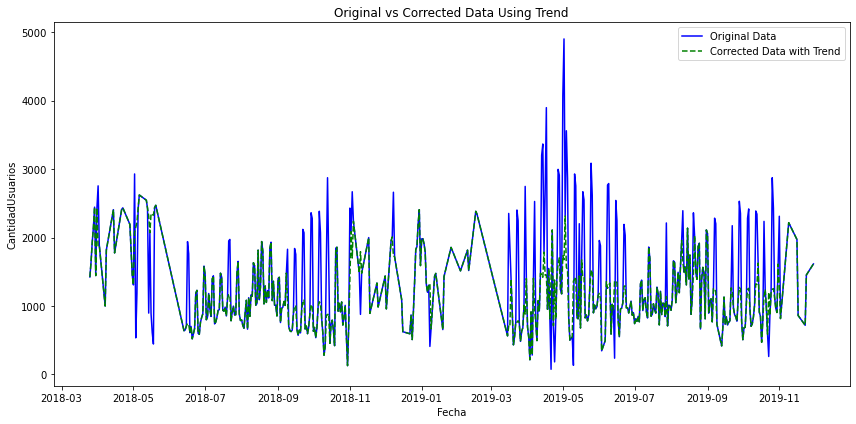

In [ ]:
corrected_data_trend = treat_outliers_with_trend(dataset['CantidadUsuarios'], result.trend)

# Visualización
plt.figure(figsize=(12, 6))
plt.plot(dataset.index, dataset['CantidadUsuarios'], label='Original Data', color='blue')
plt.plot(dataset.index, corrected_data_trend, label='Corrected Data with Trend', color='green', linestyle='--')
plt.legend()
plt.title('Original vs Corrected Data Using Trend')
plt.xlabel('Fecha')
plt.ylabel('CantidadUsuarios')
plt.tight_layout()
plt.show()


In [ ]:
data_without_seasonality = dataset['CantidadUsuarios'] - seasonal_component
